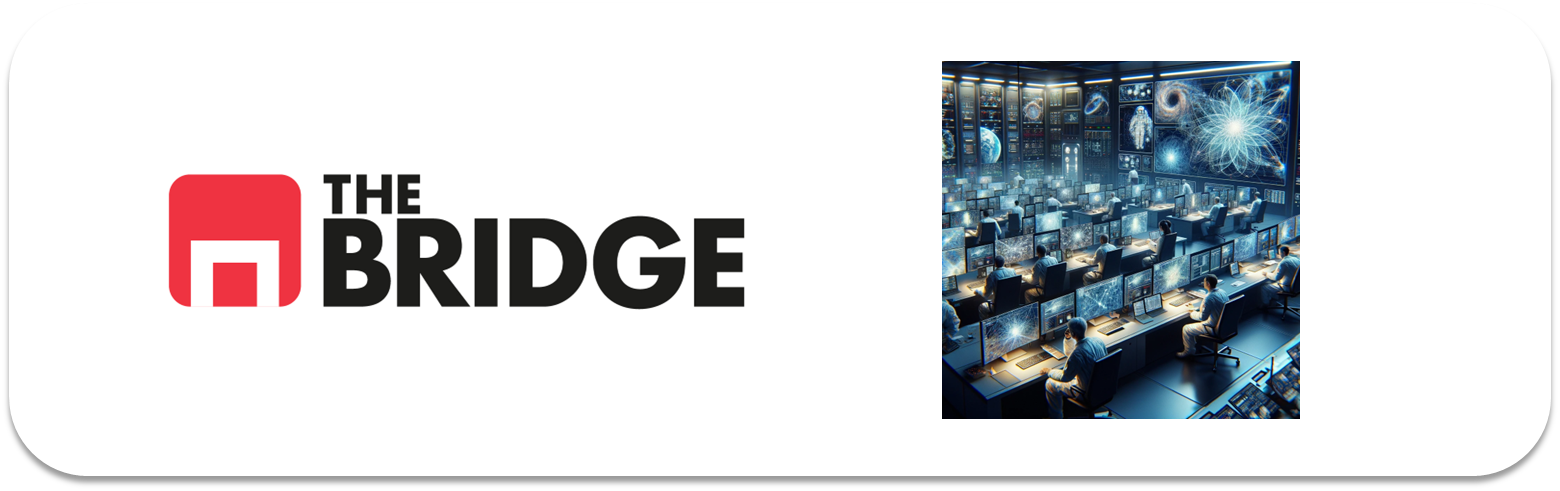

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [10]:
pip install pandas


SyntaxError: invalid syntax (3736126394.py, line 1)

In [11]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [78]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2  
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
# filter warnings
warnings.filterwarnings('ignore')
from keras.optimizers import Adam

### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



In [63]:
#cargar imagenes desde una carpeta

def cargar_imagenes_desde_directorio(ruta_dir, size=(32, 32)):
    X = []
    y = []
    for archivo in os.listdir(ruta_dir):
        if archivo.endswith(('.jpg', '.png', '.jpeg')):
            label = 0 if "cat" in archivo.lower() else 1  # 1: perro
            ruta_completa = os.path.join(ruta_dir, archivo)
            img = cv2.imread(ruta_completa)
            if img is not None:
                img = cv2.resize(img, size)
                X.append(img)
                y.append(label)
            else:
                print(f"No se pudo leer la imagen: {archivo}")
    return np.array(X), np.array(y)


In [64]:
#cargar las imagenes de entrenamiento

carpetas_train = [
    "data/github_train_0",
    "data/github_train_1",
    "data/github_train_2",
    "data/github_train_3"
]

X_train, y_train = [], []

for carpeta in carpetas_train:
    X_tmp, y_tmp = cargar_imagenes_desde_directorio(carpeta)
    X_train.extend(X_tmp)
    y_train.extend(y_tmp)

X_train = np.array(X_train)
y_train = np.array(y_train)


In [71]:
# cargamos imagnenes de test

X_test, y_test = cargar_imagenes_desde_directorio("/Users/patri/Desktop/DS24/ONLINE_DS_THEBRIDGE_PGF/SPRINT_17/UNIDAD_1/Practica_obligatoria/data/github_test")
X_test = np.array(X_test)
y_test = np.array(y_test)

In [72]:
print(X_test.shape)

(1000, 32, 32, 3)


In [19]:
#normalizamos imagene

X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0


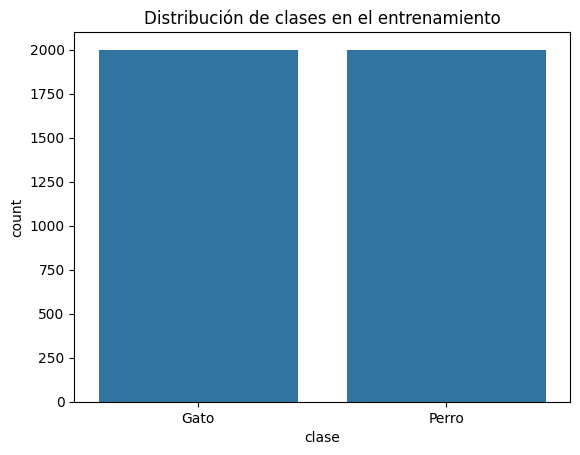

In [20]:
# Distribución de clases
df_etiquetas = pd.DataFrame(y_train, columns=["clase"])
sns.countplot(data=df_etiquetas, x="clase")
plt.title("Distribución de clases en el entrenamiento")
plt.xticks([0, 1], ["Gato", "Perro"])
plt.show();


In [23]:
#ejemplo

def mostrar_ejemplos(X, y, clase, n=6):
    idx = np.where(y == clase)[0][:n]
    plt.figure(figsize=(8, 8))
    for i, i_img in enumerate(idx):
        plt.subplot(3, 3, i+1)
        plt.imshow(X[i_img])
        plt.axis('off')
    titulo = "Ejemplos de clase: Gato" if clase == 0 else "Ejemplos de clase: Perro"
    plt.suptitle(titulo)
    plt.show()

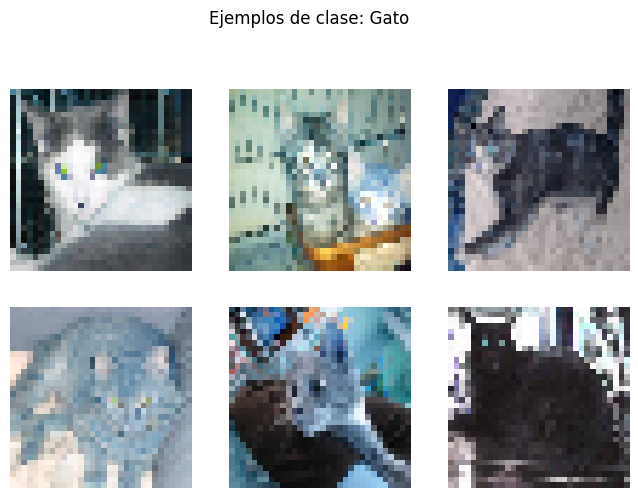

In [24]:
# Mostrar 6 gatos
mostrar_ejemplos(X_train, y_train, clase=0)

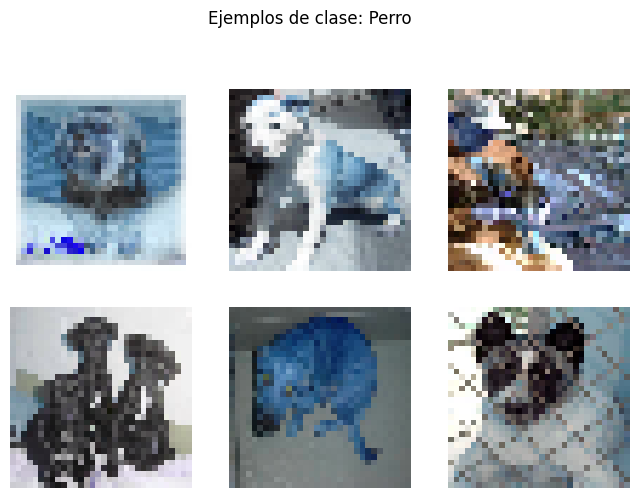

In [25]:
# Mostrar 6 perros
mostrar_ejemplos(X_train, y_train, clase=1)

In [41]:
#CNN con al menos dos juegos Convolucional-Pooling
model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = "Same", 
                 activation ="relu", input_shape = (32, 32, 3)))

model.add(MaxPool2D(pool_size=(2,2), strides = (2,2)))

model.add(Conv2D(filters=16, kernel_size=(3,3), padding="Same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Dropout(rate= 0.5))
model.add(Flatten())
model.add(Dense(2, activation = "softmax")) # 2 clases

In [42]:
optimizer = Adam(learning_rate =0.001, beta_1=0.9, beta_2=0.999)

In [43]:
model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [44]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 8)      │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,826 (14.95 KB)

 Trainable params: 3,826 (14.95 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Split para validación
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42) 

# aplicamos EarlyStopping
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [46]:
#Entrenamiento
history = model.fit(X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5144 - loss: 0.7005 - val_accuracy: 0.5900 - val_loss: 0.6852
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5667 - loss: 0.6802 - val_accuracy: 0.5075 - val_loss: 0.6838
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5935 - loss: 0.6650 - val_accuracy: 0.6925 - val_loss: 0.6244
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6441 - loss: 0.6272 - val_accuracy: 0.6350 - val_loss: 0.6455
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6538 - loss: 0.6163 - val_accuracy: 0.6575 - val_loss: 0.6009
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6902 - loss: 0.5806 - val_accuracy: 0.6975 - val_loss: 0.5707
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7006 - loss: 0.5709 - val_accuracy: 0.7100 - val_loss: 0.5653
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7020 - loss: 0.5618 - val_accu

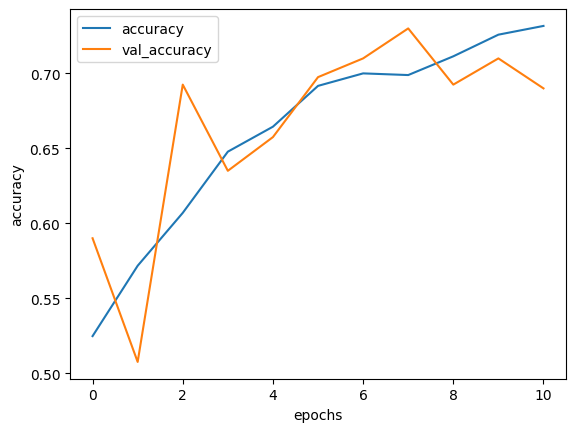

In [51]:
#visualización accuracy
history_df = pd.DataFrame(history.history)
history_df[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

In [52]:
history_df

,accuracy,loss,val_accuracy,val_loss
0,0.524722,0.693416,0.5900,0.685169
1,0.571667,0.677893,0.5075,0.683776
2,0.606944,0.656434,0.6925,0.624412
3,0.647778,0.624162,0.6350,0.645474
4,0.664444,0.608012,0.6575,0.600861
5,0.691667,0.582618,0.6975,0.570666
6,0.700000,0.570595,0.7100,0.565346
7,0.698889,0.565828,0.7300,0.556653
8,0.711389,0.554794,0.6925,0.567917
9,0.725833,0.544645,0.7100,0.568664


El modelo mejora en ambas curvas hasta las épocas 7–8.

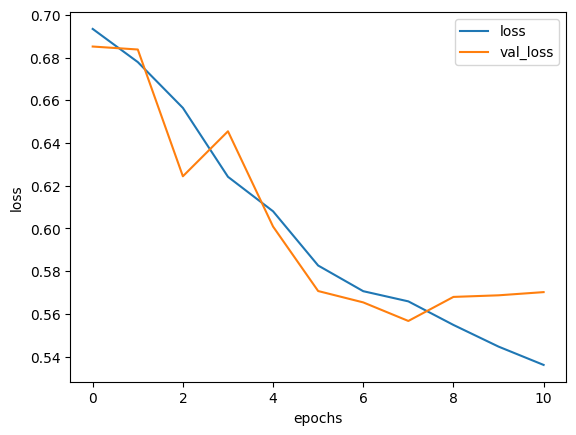

In [55]:
#visualización loss
history_df= pd.DataFrame(history.history)
history_df[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

In [61]:
X_test = np.array(X_test).astype("float32") / 255.0

In [74]:
# Evaluación del modelo
model.evaluate(X_test,y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6233 - loss: 69.2857


[66.6197509765625, 0.6439999938011169]

In [76]:
#Predicciones
y_pred = [np.argmax(prediction) for prediction in  model.predict(X_test)]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [80]:
# Classification report
print("Informe de clasificación:\n")
print(classification_report(y_test, y_pred, target_names=["Gato", "Perro"]))

Informe de clasificación:

              precision    recall  f1-score   support

        Gato       0.79      0.39      0.53       500
       Perro       0.60      0.89      0.72       500

    accuracy                           0.64      1000
   macro avg       0.69      0.64      0.62      1000
weighted avg       0.69      0.64      0.62      1000



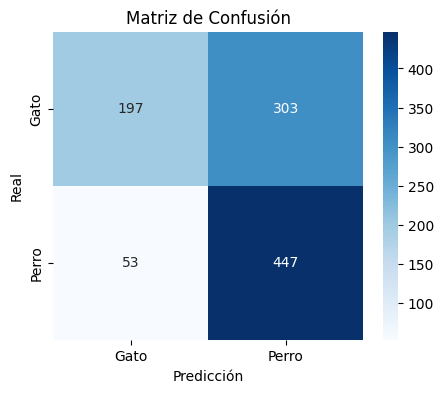

In [84]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Gato", "Perro"], yticklabels=["Gato", "Perro"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show();

- Accuracy total: 0.64 (640/1000 bien clasificadas)
- Macro avg F1: 0.62
- Clase Gato tiene bajo recall por lo que el modelo no detecta bien gatos. El modelo es bueno reconociendo perros pero no tan bueno en gatos

In [85]:
# seleccionar las imagenes mal clasificadas

# Predicciones y probabilidades
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_test

# Confianza del modelo
confianza = np.max(y_pred_prob, axis=1)

# Índices de errores
errores_index = np.where(y_pred != y_true)[0]

# Creamos DataFrame
errores_df = pd.DataFrame({
    "indice": errores_index,
    "real": y_true[errores_index],
    "predicho": y_pred[errores_index],
    "confianza_predicha": confianza[errores_index]
})

errores_df = errores_df.sort_values(by="confianza_predicha", ascending=False)

# Seleccionamos el 10% de errores
top_10_pct = int(len(errores_df) * 0.10)
errores_dificiles = errores_df.head(top_10_pct)

print("las predicciones incorrectas:")
print(errores_dificiles.head())

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
las predicciones incorrectas:
     indice  real  predicho  confianza_predicha
0         2     1         0                 1.0
230     653     0         1                 1.0
238     684     0         1                 1.0
237     679     0         1                 1.0
236     678     0         1                 1.0


Índice 2  Real: Perro (1), Predicho: Gato (0), Confianza: 1.0
Esto significa que el modelo está convencido de que es un gato, pero es un perro.
